In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import wandb
from wandb.keras import WandbCallback

from IPython.display import display

from pwas.shared_utils.util import log, get_chunk_intervals

with open('/cs/phd/nadavb/github_projects/keras_seq_vec_transformer/keras_seq_vec_transformer.py', 'r') as f:
    '''
    Some horrible hacks. To make keras_seq_vec_transformer work with tf.keras instead of just keras we run the following instead of
    just exec(f.read()).
    Note that also above we run from tensorflow import keras instead of just import keras
    '''
    import tensorflow.keras.backend as K 
    from tensorflow.keras.layers import LayerNormalization
    exec('\n'.join([line for line in f.read().splitlines() if not line.startswith('import keras') and not \
            line.startswith('from keras_layer_normalization')]))

In [75]:
def mkdir_if_not_exists(directory):
    if not os.path.isdir(directory):
        os.mkdir(directory)

def save_model(model, path):
    with open(path, 'wb') as f:
        pickle.dump((model.get_weights(), model.optimizer.get_weights()), f)
        
def load_model(model, path):
    with open(path, 'rb') as f:
        model_weights, optimizer_weights = pickle.load(f)
        model.set_weights(model_weights)
        model.optimizer.set_weights(optimizer_weights)

class AutoSaveCallback(keras.callbacks.Callback):
    
    def __init__(self, directory, epochs_offset = 0, every_epochs_to_save = 1, every_saves_to_keep = 25):
        self.directory = directory
        self.epochs_offset = epochs_offset
        self.every_epochs_to_save = every_epochs_to_save
        self.every_saves_to_keep = every_saves_to_keep
        self.last_saved_path_to_delete = None
        self.n_saves = 0
    
    def on_epoch_end(self, epoch, logs = None):
        
        epoch += self.epochs_offset + 1
        
        if epoch % self.every_epochs_to_save != 0:
            return
        
        save_path = os.path.join(self.directory, 'epoch-%d.pkl' % epoch)
        save_model(self.model, save_path)
        self.n_saves += 1
        
        if self.last_saved_path_to_delete is not None:
            os.remove(self.last_saved_path_to_delete)
            
        if self.n_saves % self.every_saves_to_keep != 0:
            self.last_saved_path_to_delete = save_path

In [2]:
tf.test.is_gpu_available()

True

In [3]:
wandb.init(project = 'protobert', dir = '/cs/phd/nadavb/my_storage/wandb')

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


W&B Run: https://app.wandb.ai/nadavb/protobert/runs/2yuphi1y

In [4]:
MAX_SEQ_LENGTH = 400
N_TEST_SET = 1000000

ALL_AAS = 'ACDEFGHIKLMNPQRSTUVWXY'

H5_FILE_PATH = '/cs/phd/nadavb/cafa_project/data/dataset.h5'

BASE_WEIGHTS_DIR = '/cs/phd/nadavb/cafa_project/data/model_weights'

In [ ]:
run_weights_dir = os.path.join(BASE_WEIGHTS_DIR, wandb.run.name)
mkdir_if_not_exists(run_weights_dir)

auto_save_weights_dir = os.path.join(run_weights_dir, 'autosave')
mkdir_if_not_exists(auto_save_weights_dir)

8943 unique annotations.


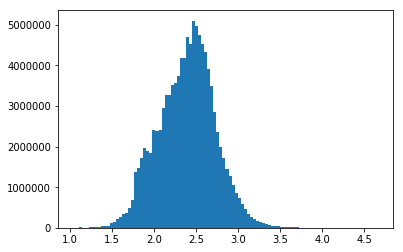

In [5]:
with h5py.File(H5_FILE_PATH, 'r') as h5f:
    included_annotation_indices = h5f['included_annotation_indices'][:]
    seq_lengths = h5f['seq_lengths'][:]
    
n_annotations = len(included_annotation_indices)
print('%d unique annotations.' % n_annotations)
    
fig, ax = plt.subplots()
_ = ax.hist(np.log10(seq_lengths), bins = 100)

In [6]:
relevant_seq_length_indice, = np.where(seq_lengths <= MAX_SEQ_LENGTH)

np.random.seed(0)
test_set_mask = np.zeros_like(relevant_seq_length_indice, dtype = bool)
test_set_mask[:N_TEST_SET] = True
np.random.shuffle(test_set_mask)

test_set_indices = relevant_seq_length_indice[test_set_mask]
training_set_indices = relevant_seq_length_indice[~test_set_mask]

del test_set_mask, relevant_seq_length_indice

print('Test-set size: %d proteins, training-set size: %d proteins.' % (len(training_set_indices), len(test_set_indices)))

Test-set size: 77352183 proteins, training-set size: 1000000 proteins.


In [77]:
n_aas = len(ALL_AAS)
other_aa_token = n_aas
pad_token = n_aas + 1
n_seq_tokens = n_aas + 2
aa_to_token = {aa: i for i, aa in enumerate(ALL_AAS)}

token_to_str = dict(enumerate(ALL_AAS))
token_to_str[n_aas] = '<OTHER>'
token_to_str[n_aas + 1] = '<PAD>'

def tokenize_seqs(seqs, max_length):
    
    tokenized_seqs = np.zeros((len(seqs), max_length), dtype = np.int8)
    
    for i, seq in enumerate(seqs):
        
        assert len(seq) <= max_length
        
        for j, aa in enumerate(seq):
            tokenized_seqs[i, j] = aa_to_token.get(aa, other_aa_token)
            
        tokenized_seqs[i, len(seq):] = pad_token
        
    return tokenized_seqs

def iter_dataset(indices, chunk_size = 10000, record_offset = 0):
    
    indices = indices[(record_offset % len(indices)):]
    
    with h5py.File(H5_FILE_PATH, 'r') as h5f: 
        for i1, i2 in get_chunk_intervals(len(indices), chunk_size):
            
            chunk_indices = indices[i1:i2]
            chunk_seqs = h5f['seqs'][chunk_indices]
            chunk_annotation_masks = h5f['annotation_masks'][chunk_indices]
            
            for seq, annotation_mask in zip(chunk_seqs, chunk_annotation_masks):
                yield seq, annotation_mask
                
def iter_dataset_forever(indices, chunk_size = 10000, record_offset = 0):
    
    iteration = 0
    
    while True:
        
        iteration += 1
        log('Iteration #%d over the datasdet...' % iteration)
        
        if record_offset != 0:
            log('Starting from record %d.' % record_offset)
        
        for seq, annotation_mask in iter_dataset(indices, chunk_size = chunk_size, record_offset = record_offset):
            yield seq, annotation_mask
            
        record_offset = 0
            
def generate_batches(dataset_indices, p_seq_noise = 0.1, p_no_input_annot = 0.5, p_annot_noise_positive = 0.25, \
        p_annot_noise_negative = 1e-04, batch_size = 64, chunk_size = 10000, record_offset = 0):
    
    dataset_iter = iter_dataset_forever(dataset_indices, chunk_size = chunk_size, record_offset = record_offset)
    
    while True:
        
        batch_data = [next(dataset_iter) for _ in range(batch_size)]
        batch_seqs, batch_annotation_masks = map(list, zip(*batch_data))

        batch_true_seqs_tokens = tokenize_seqs(batch_seqs, MAX_SEQ_LENGTH)
        batch_true_annotation_masks = np.concatenate([annotation_mask.reshape(1, -1) for annotation_mask in batch_annotation_masks], axis = 0)
        
        batch_seqs_mask = np.random.choice([True, False], batch_true_seqs_tokens.shape, p = [1 - p_seq_noise, p_seq_noise])
        batch_random_seqs_tokens = np.random.randint(0, n_seq_tokens, batch_true_seqs_tokens.shape)
        batch_noisy_seqs_tokens = np.where(batch_seqs_mask, batch_true_seqs_tokens, batch_random_seqs_tokens)
        
        batch_noisy_annotations_when_positive = np.random.choice([True, False], batch_true_annotation_masks.shape, \
                p = [1 - p_annot_noise_positive, p_annot_noise_positive])
        batch_noisy_annotations_when_negative = np.random.choice([True, False], batch_true_annotation_masks.shape, \
                p = [p_annot_noise_negative, 1 - p_annot_noise_negative])
        batch_noisy_annotation_masks = np.where(batch_true_annotation_masks, batch_noisy_annotations_when_positive, \
                batch_noisy_annotations_when_negative)
        batch_noisy_annotation_masks[np.random.choice([True, False], batch_size, p = [p_no_input_annot, 1 - p_no_input_annot]), :] = False
        
        yield [batch_noisy_seqs_tokens, batch_noisy_annotation_masks.astype(np.int8)], [np.expand_dims(batch_true_seqs_tokens, axis = -1), \
                batch_true_annotation_masks.astype(np.int8)]

In [8]:
input_seq_layer = keras.layers.Input(shape = (MAX_SEQ_LENGTH,), dtype = np.int32, name = 'input-seq')
input_annoatations_layer = keras.layers.Input(shape = (n_annotations,), dtype = np.float32, name = 'input-annotations')
output_seq_layer, output_annoatations_layer = TransformerAutoEncoder(vocab_size = n_seq_tokens, d_vec = n_annotations, \
        output_vec_activation = 'sigmoid', name = 'auto-encoder')([input_seq_layer, input_annoatations_layer])

# An ugly hack meant to achieve nothing than renaming those layers.
output_seq_layer = keras.layers.Reshape(output_seq_layer.shape[1:], name = 'output_seq_layer')(output_seq_layer)
output_annoatations_layer = keras.layers.Reshape(output_annoatations_layer.shape[1:], name = 'output_annoatations_layer')\
        (output_annoatations_layer)

model = keras.models.Model(inputs = [input_seq_layer, input_annoatations_layer], outputs = [output_seq_layer, output_annoatations_layer])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input-seq (InputLayer)          [(None, 400)]        0                                            
__________________________________________________________________________________________________
input-annotations (InputLayer)  [(None, 8943)]       0                                            
__________________________________________________________________________________________________
auto-encoder (TransformerAutoEn [(None, 400, 24), (N 24987399    input-seq[0][0]                  
                                                                 input-annotations[0][0]          
__________________________________________________________________________________________________
output_seq_layer (Reshape)      (None, 400, 24)      0           auto-encoder[0][0]           

In [ ]:
# RESUME_FROM_EPOCH_SAVE = None
RESUME_FROM_EPOCH_SAVE = 5240

wandb.config.batch_size = 32
wandb.config.steps_per_epoch = 100

if RESUME_FROM_EPOCH_SAVE is None:
    wandb.config.lr = 2e-04
    wandb.config.annots_loss_weight = 1e02
    print('Compiling model...')
    model.compile(optimizer = keras.optimizers.Adam(lr = wandb.config.lr), loss = ['sparse_categorical_crossentropy', 'binary_crossentropy'], \
            loss_weights = [1, wandb.config.annots_loss_weight])
    epochs_offset = 0
else:
    save_path = os.path.join(run_weights_dir, 'epoch-%d.pkl' % RESUME_FROM_EPOCH_SAVE)
    print('Loading model %s...' % save_path)
    load_model(model, save_path)
    epochs_offset = RESUME_FROM_EPOCH_SAVE

record_offset = epochs_offset * wandb.config.steps_per_epoch * wandb.config.batch_size
np.random.seed(0)
model.fit_generator(generate_batches(training_set_indices, batch_size = wandb.config.batch_size, record_offset = record_offset), \
        steps_per_epoch = wandb.config.steps_per_epoch, epochs = 100000, callbacks = [WandbCallback(), \
        AutoSaveCallback(auto_save_weights_dir, epochs_offset = epochs_offset, every_epochs_to_save = 10)])

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Loading model /cs/phd/nadavb/cafa_project/data/model_weights/whole-donkey-13/epoch-5240.pkl...
[2020_06_11-10:50:40] Iteration #1 over the datasdet...
Epoch 1/100000
[2020_06_11-10:50:40] Starting from record 16768000.
100/100 [==============================] - 45s 448ms/step - loss: 0.2802 - output_seq_layer_loss: 0.2624 - output_annoatations_layer_loss: 1.7837e-04
Epoch 2/100000
100/100 [==============================] - 42s 424ms/step - loss: 0.2785 - output_seq_layer_loss: 0.2604 - output_annoatations_layer_loss: 1.8106e-04
Epoch 3/100000
100/100 [==============================] - 42s 423ms/step - loss: 0.2793 - output_seq_layer_loss: 0.2601 - output_annoatations_layer_loss: 1.9242e-04
Epoch 4/100000
100/100 [==============================] - 46s 457ms/step - loss: 0.2826 - output_seq_layer_loss: 0.2621 - output_annoatations_layer_loss: 2.0486e-04
Epoch 5/100000
100/100 [==============================] - 42s 424ms/step - loss: 0.2782 - output_seq_layer_loss: 0.2581 - output_annoata

In [22]:
record_index = test_set_indices[1]

with h5py.File(H5_FILE_PATH, 'r') as h5f:
    uniprot_id = h5f['uniprot_ids'][record_index]
    
print('UniProt ID: %s (https://www.uniprot.org/uniprot/%s)' % (uniprot_id, uniprot_id))

(X_seqs, X_annots), (Y_true_seqs, Y_true_annots) = next(generate_batches([record_index], batch_size = 1, chunk_size = 1))
Y_pred_seqs, Y_pred_annots = model.predict([X_seqs, X_annots])

X_seqs = X_seqs.flatten()
X_annots = X_annots.flatten()
Y_true_seqs = Y_true_seqs.flatten()
Y_true_annots = Y_true_annots.flatten()
Y_pred_seqs = Y_pred_seqs[0, :, :]
Y_pred_annots = Y_pred_annots.flatten()
Y_pred_seqs_max = Y_pred_seqs.argmax(axis = -1)

seq_result = pd.DataFrame()
seq_result['true'] = list(map(token_to_str.get, Y_true_seqs))
seq_result['input'] = list(map(token_to_str.get, X_seqs))
seq_result['max'] = list(map(token_to_str.get, Y_pred_seqs_max))
seq_result['p_true'] = Y_pred_seqs[np.arange(MAX_SEQ_LENGTH), Y_true_seqs]
seq_result['p_input'] = Y_pred_seqs[np.arange(MAX_SEQ_LENGTH), X_seqs]
seq_result['p_max'] = Y_pred_seqs[np.arange(MAX_SEQ_LENGTH), Y_pred_seqs_max]

print('Sequence results:')

with pd.option_context('display.max_columns', MAX_SEQ_LENGTH):
    display(seq_result[(seq_result['true'] != seq_result['input']) | (seq_result['p_true'] < 0.9)].transpose())
    
true_annots = np.where(Y_true_annots)[0]
input_annots = np.where(X_annots)[0]
relevant_annots = sorted(set(true_annots) | set(input_annots) | set(np.where(Y_pred_annots >= 0.05)[0]))
    
print('Annotation results:')
print('True annotations: %s' % true_annots)
print('Input annotations: %s' % input_annots)
print('Predicted annotations: %s' % ', '.join('%d (%.2g)' % (annot, Y_pred_annots[annot]) for annot in relevant_annots))

UniProt ID: A0A365T8E7_9EURY (https://www.uniprot.org/uniprot/A0A365T8E7_9EURY)
[2020_06_11-09:02:19] Iteration #1 over the datasdet...
Sequence results:


,0,3,10,11,22,51,67,69,72,77,82,84,88,90,96,97,101,106,107,127,129,134,136,137,138,140,142,153,168,171,172,174,176,180,183,184,185,186,190,193,195,197,199,200,201,203,204,205,210,213,214,216,218,220,221,233,237,253,254,255,257,259,269,270,272,275,279,281,285,286,293,294,296,299,301,302,303,304,305,308,309,311,321,324,344,347,349,351,393,394
true,M,A,L,H,G,S,D,Q,M,S,W,S,I,F,G,L,A,M,M,Q,Q,Y,D,D,K,N,P,T,N,L,A,Q,Q,N,N,A,W,F,T,S,E,E,R,E,R,D,E,M,E,H,L,D,Y,G,N,G,M,N,P,S,T,N,D,Q,Y,C,H,M,M,N,V,M,Q,K,M,Q,G,T,P,V,Q,D,G,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>
input,D,C,I,H,G,V,D,Q,M,S,W,I,U,F,V,G,<OTHER>,M,M,Q,H,X,D,D,K,N,P,G,N,L,M,Q,Q,N,N,M,W,F,T,S,W,G,I,E,R,W,E,M,E,H,X,H,Y,G,N,G,M,N,P,P,X,N,D,Q,Y,P,H,M,M,P,D,M,Q,K,M,Q,G,C,E,K,Q,D,G,Y,E,I,L,N,L,K
max,M,C,I,H,G,V,D,Q,M,S,W,I,L,F,V,G,L,M,M,Q,H,L,D,D,K,N,P,G,N,L,D,Q,Q,N,N,M,W,F,T,S,W,G,I,E,R,W,E,M,E,H,L,H,Y,G,N,G,M,N,P,P,E,N,D,Q,Y,P,H,M,M,P,D,M,Q,K,M,Q,G,C,E,K,Q,D,G,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>,<PAD>
p_true,0.932644,0.0487611,0.00862729,0.873806,0.852475,0.0146901,0.897791,0.896382,0.857139,0.892149,0.486972,0.00332719,0.0691604,0.898,0.00358824,0.00281589,0.137417,0.7842,0.791875,0.885027,0.00622065,0.0390215,0.871884,0.869986,0.881525,0.801306,0.83184,0.00255193,0.824488,0.866605,0.00216684,0.583395,0.862437,0.898946,0.886613,0.0184474,0.723021,0.89957,0.896812,0.899173,0.015542,0.0122734,0.00190007,0.855374,0.883319,0.0125678,0.794823,0.819927,0.756204,0.87644,0.156918,0.00444508,0.839795,0.895073,0.871421,0.8905,0.76859,0.893645,0.88894,0.00935091,0.0541376,0.847755,0.886054,0.897201,0.882212,0.00442891,0.851009,0.816804,0.823067,0.00425702,0.00470254,0.843416,0.877819,0.887906,0.879245,0.860611,0.874766,0.0291987,0.00211714,0.0122999,0.832863,0.832968,0.898422,0.999744,1,1,1,1,1,1
p_input,0.062901,0.249568,0.959875,0.873806,0.852475,0.871916,0.897791,0.896382,0.857139,0.892149,0.486972,0.95086,2.50571e-05,0.898,0.963632,0.977931,2.0718e-06,0.7842,0.791875,0.885027,0.831567,0.00720158,0.871884,0.869986,0.881525,0.801306,0.83184,0.975113,0.824488,0.866605,0.448441,0.583395,0.862437,0.898946,0.886613,0.819643,0.723021,0.89957,0.896812,0.899173,0.66657,0.868406,0.973051,0.855374,0.883319,0.393833,0.794823,0.819927,0.756204,0.87644,0.0124558,0.808249,0.839795,0.895073,0.871421,0.8905,0.76859,0.893645,0.88894,0.860916,0.0126288,0.847755,0.886054,0.897201,0.882212,0.72591,0.851009,0.816804,0.823067,0.854694,0.935329,0.843416,0.877819,0.887906,0.879245,0.860611,0.874766,0.330974,0.938256,0.865413,0.832863,0.832968,0.898422,3.53456e-05,9.68169e-13,1.68533e-14,1.04748e-14,2.08496e-13,9.02285e-15,5.2488e-13
p_max,0.932644,0.249568,0.959875,0.873806,0.852475,0.871916,0.897791,0.896382,0.857139,0.892149,0.486972,0.95086,0.12316,0.898,0.963632,0.977931,0.160395,0.7842,0.791875,0.885027,0.831567,0.213972,0.871884,0.869986,0.881525,0.801306,0.83184,0.975113,0.824488,0.866605,0.51716,0.583395,0.862437,0.898946,0.886613,0.819643,0.723021,0.89957,0.896812,0.899173,0.66657,0.868406,0.973051,0.855374,0.883319,0.393833,0.794823,0.819927,0.756204,0.87644,0.156918,0.808249,0.839795,0.895073,0.871421,0.8905,0.76859,0.893645,0.88894,0.860916,0.0982833,0.847755,0.886054,0.897201,0.882212,0.72591,0.851009,0.816804,0.823067,0.854694,0.935329,0.843416,0.877819,0.887906,0.879245,0.860611,0.874766,0.330974,0.938256,0.865413,0.832863,0.832968,0.898422,0.999744,1,1,1,1,1,1


Annotation results:
True annotations: [1427 3945]
Input annotations: [1427]
Predicted annotations: 1427 (0.99), 3945 (0.66)
